## Импорт библиотек и константы

In [124]:
import json
import pickle
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import faiss

from scipy import sparse
from tqdm import tqdm

from rectools import Columns
from rectools.dataset import Interactions, Dataset
from rectools.models.popular import PopularModel
from rectools.metrics import MAP, Serendipity, calc_metrics
from rectools.model_selection import TimeRangeSplitter
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel

from lightfm import LightFM
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # implicit.ALS

In [4]:
INTERACTIONS_PATH = "./data/interactions.csv"
ITEMS_PATH = "./data/items.csv"
USERS_PATH = "./data/users.csv"
K_RECOMMENDATIONS = 10
RANDOM_STATE = 0

## Загрузка данных

In [5]:
interactions_df = pd.read_csv(INTERACTIONS_PATH)
interactions_df = interactions_df.rename(columns={"watched_pct": "weight", "last_watch_dt": "datetime"})
interactions_df['datetime'] = pd.to_datetime(interactions_df['datetime'])
interactions_df = interactions_df[interactions_df["total_dur"] > 300]
interactions_df = interactions_df.dropna()
interactions_df.head(5)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0


In [6]:
items_df = pd.read_csv(ITEMS_PATH)
items_df.head(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [7]:
users_df = pd.read_csv(USERS_PATH)
users_df.head(5)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


## Эксперименты

#### Визуализация признаков юзеров

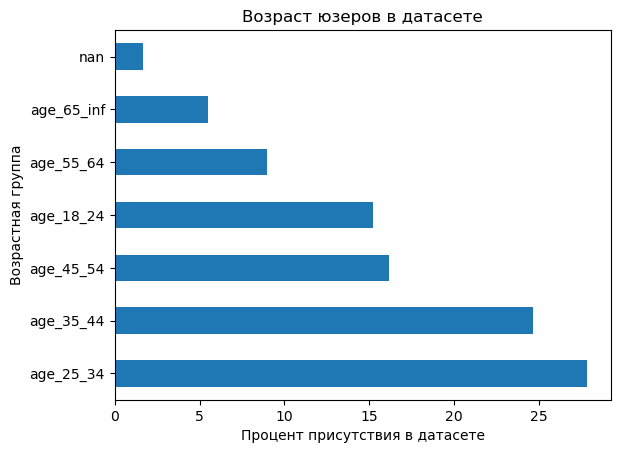

In [8]:
(users_df["age"].value_counts(normalize=True, dropna=False) * 100).plot(kind="barh")
plt.title("Возраст юзеров в датасете")
plt.ylabel("Возрастная группа")
plt.xlabel("Процент присутствия в датасете")
plt.show()

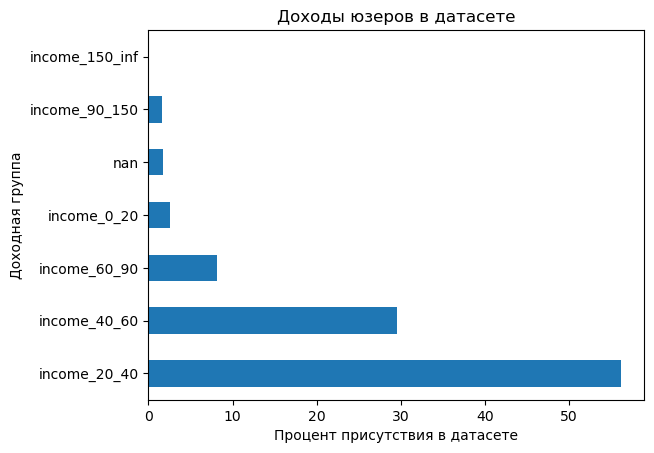

In [9]:
(users_df["income"].value_counts(normalize=True, dropna=False) * 100).plot(kind="barh")
plt.title("Доходы юзеров в датасете")
plt.ylabel("Доходная группа")
plt.xlabel("Процент присутствия в датасете")
plt.show()

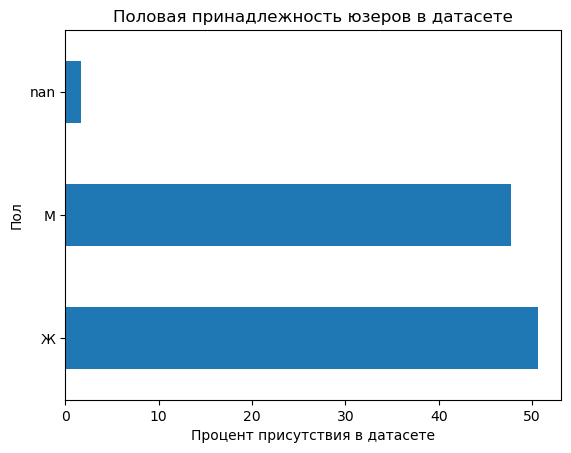

In [10]:
(users_df["sex"].value_counts(normalize=True, dropna=False) * 100).plot(kind="barh")
plt.title("Половая принадлежность юзеров в датасете")
plt.ylabel("Пол")
plt.xlabel("Процент присутствия в датасете")
plt.show()

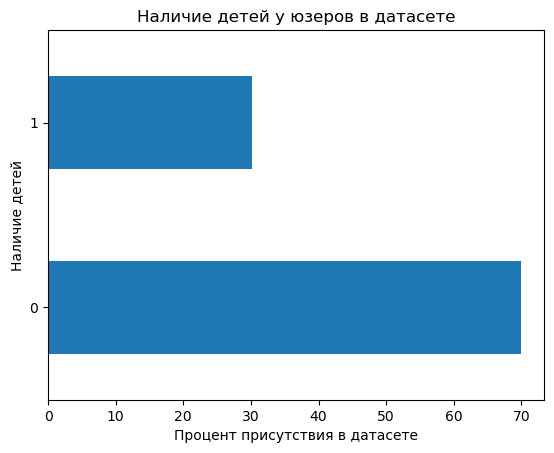

In [11]:
(users_df["kids_flg"].value_counts(normalize=True, dropna=False) * 100).plot(kind="barh")
plt.title("Наличие детей у юзеров в датасете")
plt.ylabel("Наличие детей")
plt.xlabel("Процент присутствия в датасете")
plt.show()

Создадим датафрейм с фичами пользователей

In [12]:
user_features_frames = []
for feature in ["age", "income", "sex", "kids_flg"]:
    feature_frame = users_df.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features_df = pd.concat(user_features_frames)

In [13]:
user_features_df.sample(5)

,id,value,feature
556756,401308,income_40_60,income
627895,456402,age_25_34,age
237270,901050,Ж,sex
72351,113444,Ж,sex
211162,1016317,income_20_40,income


#### Визуализация признаков айтемов

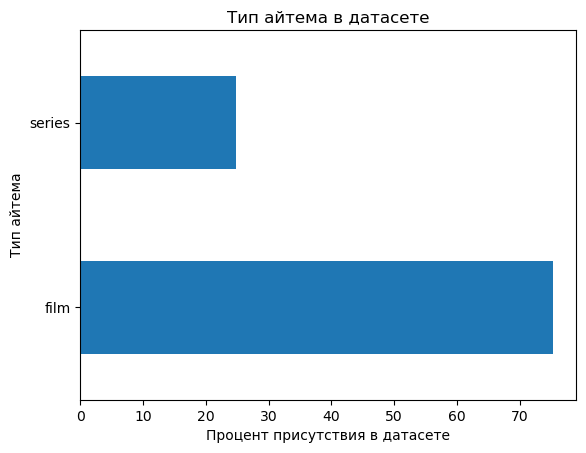

In [14]:
(items_df["content_type"].value_counts(normalize=True, dropna=False) * 100).plot(kind="barh")
plt.title("Тип айтема в датасете")
plt.ylabel("Тип айтема")
plt.xlabel("Процент присутствия в датасете")
plt.show()

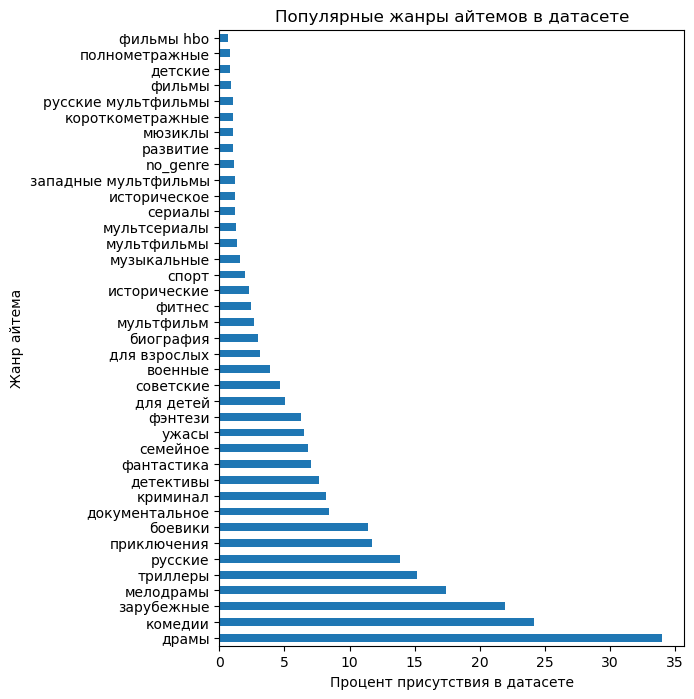

In [15]:
genres_df = items_df["genres"].map(lambda x: x.split(", ")).explode().value_counts()
genres_df = genres_df[genres_df > 100]
plt.figure(figsize=(6, 8))
(genres_df / len(items_df) * 100).plot(kind="barh")
plt.title("Популярные жанры айтемов в датасете")
plt.ylabel("Жанр айтема")
plt.xlabel("Процент присутствия в датасете")
plt.show()

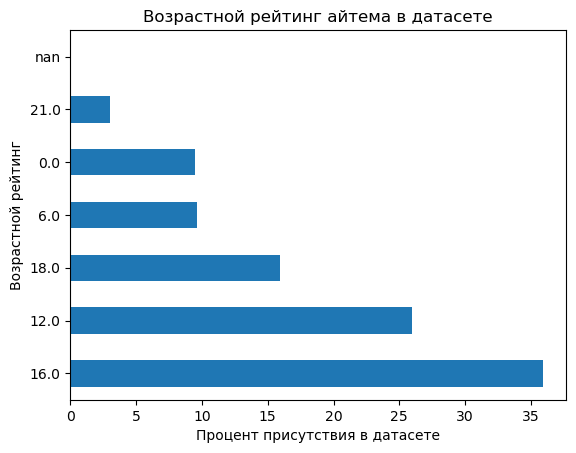

In [16]:
(items_df["age_rating"].value_counts(normalize=True, dropna=False) * 100).plot(kind="barh")
plt.title("Возрастной рейтинг айтема в датасете")
plt.ylabel("Возрастной рейтинг")
plt.xlabel("Процент присутствия в датасете")
plt.show()

Создадим датафреймы с фичами айтемов

In [17]:
items_df["genre"] = items_df["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
items_genres_df = items_df[["item_id", "genre"]].explode("genre")
items_genres_df.columns = ["id", "value"]
items_genres_df["feature"] = "genre"
items_genres_df.sample(5)

,id,value,feature
6800,6709,драмы,genre
990,8637,зарубежные,genre
1017,2755,комедии,genre
14376,3259,мелодрамы,genre
6682,14466,драмы,genre


In [18]:
items_content_type_df = items_df.reindex(columns=[Columns.Item, "content_type"])
items_content_type_df.columns = ["id", "value"]
items_content_type_df["feature"] = "content_type"
items_content_type_df.sample(5)

,id,value,feature
7580,8405,series,content_type
6588,11953,film,content_type
6147,11897,film,content_type
5059,6639,film,content_type
10057,6630,film,content_type


In [19]:
items_age_rating_df = items_df.reindex(columns=[Columns.Item, "age_rating"])
items_age_rating_df.columns = ["id", "value"]
items_age_rating_df["feature"] = "age_rating"
items_age_rating_df.sample(5)

,id,value,feature
6937,6034,18.0,age_rating
15075,4775,6.0,age_rating
8709,8168,16.0,age_rating
8633,11476,18.0,age_rating
12630,7412,16.0,age_rating


In [20]:
item_features_df = pd.concat((items_genres_df, items_content_type_df, items_age_rating_df))

In [21]:
item_features_df.sample(5)

,id,value,feature
10729,1053,драмы,genre
7141,12120,зарубежные,genre
10744,4445,series,content_type
2271,13674,0.0,age_rating
6081,1962,film,content_type


### Тюнинг гиперпараметров для моделей (3 балла)

#### Подготовка

In [22]:
tuning_interactions = Interactions(interactions_df)

In [23]:
tuning_metrics = {
    'map@10': MAP(k=K_RECOMMENDATIONS)
}

In [24]:
tuning_splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=1,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True
)

In [25]:
def train_and_calculate_score(model, interactions, splitter, metrics, head_metric="map@10", use_features=False):
    fold_iterator = splitter.split(interactions, collect_fold_stats=True)
    results = []

    for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
        df_train = interactions.df.iloc[train_ids].copy()
        df_test = interactions.df.iloc[test_ids].copy()
        test_users = df_test[Columns.User].unique()
        catalog = df_train[Columns.Item].unique()
        
        current_user_features_df = user_features_df[user_features_df["id"].isin(df_train[Columns.User].unique())]
        current_item_features_df = item_features_df[item_features_df["id"].isin(df_train[Columns.Item].unique())]

        if use_features:
            dataset = Dataset.construct(
                df_train,
                user_features_df=current_user_features_df,
                cat_user_features=["age", "income", "sex", "kids_flg"],
                item_features_df=current_item_features_df,
                cat_item_features=["genre", "content_type", "age_rating"],
            )
        else:
            dataset = Dataset.construct(df_train)
        
        model.fit(dataset)
        recos = model.recommend(test_users, dataset, k=K_RECOMMENDATIONS, filter_viewed=True)
        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train,
            catalog=catalog,
        )
        results.append(metric_values)

    return np.mean(np.array([item[head_metric] for item in results]))

In [26]:
# from optuna.study to format "model-value"
def preapare_dataframe(dataframe, model_name, params, threshold=0.06):
    df = dataframe.copy()
    df["model"] =  model_name
    for param in params:
        df["model"] = df["model"] + "_" + dataframe[f"params_{param}"].apply(str)
    df = df[["model", "value"]]
    df = df[df["value"] >= threshold]
    df = df.sort_values("value", ascending=False)
    return df

#### Тюнинг ALS

In [27]:
ALS_N_TRIALS = 20

In [31]:
def als_objective(trial: optuna.Trial):
    global tuning_interactions, tuning_splitter, tuning_metrics
    
    factors = trial.suggest_categorical("factors", [32, 64, 100, 128, 256])
    regularization = trial.suggest_categorical("regularization", [1e-2, 5e-2, 1e-1])
    alpha = trial.suggest_categorical("alpha", [0.1, 1, 5, 10])
    use_features = trial.suggest_categorical("use_features", [True, False])
    iterations = trial.suggest_categorical("iterations", [5, 10, 15])
    
    als_model = ImplicitALSWrapperModel(
        model=AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            alpha=alpha,
            iterations=iterations,
            random_state=RANDOM_STATE,
        ),
        fit_features_together=use_features,
        verbose=True
    )
    
    score = train_and_calculate_score(als_model, tuning_interactions, tuning_splitter, tuning_metrics, use_features=use_features)
    return score

In [32]:
als_study = optuna.create_study(direction="maximize", study_name="ALS", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.NopPruner())
als_study.optimize(als_objective, n_trials=ALS_N_TRIALS) 

[I 2023-12-12 09:20:48,716] A new study created in memory with name: ALS


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-12-12 09:22:12,214] Trial 0 finished with value: 0.07615304538382477 and parameters: {'factors': 64, 'regularization': 0.01, 'alpha': 1, 'use_features': True, 'iterations': 5}. Best is trial 0 with value: 0.07615304538382477.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-12-12 09:23:52,898] Trial 1 finished with value: 0.029635314246008924 and parameters: {'factors': 256, 'regularization': 0.1, 'alpha': 1, 'use_features': False, 'iterations': 5}. Best is trial 0 with value: 0.07615304538382477.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-12-12 09:24:39,479] Trial 2 finished with value: 0.022164558724569444 and parameters: {'factors': 64, 'regularization': 0.1, 'alpha': 10, 'use_features': False, 'iterations': 5}. Best is trial 0 with value: 0.07615304538382477.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-12-12 09:29:38,485] Trial 3 finished with value: 0.07205369487399552 and parameters: {'factors': 128, 'regularization': 0.1, 'alpha': 10, 'use_features': True, 'iterations': 15}. Best is trial 0 with value: 0.07615304538382477.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-12-12 09:31:21,503] Trial 4 finished with value: 0.03090660159183525 and parameters: {'factors': 64, 'regularization': 0.1, 'alpha': 10, 'use_features': False, 'iterations': 15}. Best is trial 0 with value: 0.07615304538382477.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-12-12 09:32:05,699] Trial 5 finished with value: 0.03284613135212142 and parameters: {'factors': 64, 'regularization': 0.05, 'alpha': 0.1, 'use_features': False, 'iterations': 5}. Best is trial 0 with value: 0.07615304538382477.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-12-12 09:33:29,866] Trial 6 finished with value: 0.05072246936434083 and parameters: {'factors': 64, 'regularization': 0.05, 'alpha': 10, 'use_features': True, 'iterations': 5}. Best is trial 0 with value: 0.07615304538382477.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-12-12 09:35:06,306] Trial 7 finished with value: 0.07621772207533736 and parameters: {'factors': 100, 'regularization': 0.01, 'alpha': 1, 'use_features': True, 'iterations': 5}. Best is trial 7 with value: 0.07621772207533736.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-12-12 09:36:51,964] Trial 8 finished with value: 0.03460729853172093 and parameters: {'factors': 64, 'regularization': 0.01, 'alpha': 10, 'use_features': False, 'iterations': 15}. Best is trial 7 with value: 0.07621772207533736.


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-12-12 09:37:33,795] Trial 9 finished with value: 0.02655071376166341 and parameters: {'factors': 64, 'regularization': 0.1, 'alpha': 5, 'use_features': False, 'iterations': 5}. Best is trial 7 with value: 0.07621772207533736.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-12 09:40:27,263] Trial 10 finished with value: 0.08396154411101982 and parameters: {'factors': 100, 'regularization': 0.01, 'alpha': 1, 'use_features': True, 'iterations': 10}. Best is trial 10 with value: 0.08396154411101982.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-12 09:43:19,852] Trial 11 finished with value: 0.08396154411101982 and parameters: {'factors': 100, 'regularization': 0.01, 'alpha': 1, 'use_features': True, 'iterations': 10}. Best is trial 10 with value: 0.08396154411101982.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-12 09:46:11,266] Trial 12 finished with value: 0.08396154411101982 and parameters: {'factors': 100, 'regularization': 0.01, 'alpha': 1, 'use_features': True, 'iterations': 10}. Best is trial 10 with value: 0.08396154411101982.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-12 09:49:05,258] Trial 13 finished with value: 0.08396154411101982 and parameters: {'factors': 100, 'regularization': 0.01, 'alpha': 1, 'use_features': True, 'iterations': 10}. Best is trial 10 with value: 0.08396154411101982.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-12 09:51:14,356] Trial 14 finished with value: 0.07819120186903519 and parameters: {'factors': 32, 'regularization': 0.01, 'alpha': 0.1, 'use_features': True, 'iterations': 10}. Best is trial 10 with value: 0.08396154411101982.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-12 09:54:06,537] Trial 15 finished with value: 0.07768072002951644 and parameters: {'factors': 100, 'regularization': 0.01, 'alpha': 5, 'use_features': True, 'iterations': 10}. Best is trial 10 with value: 0.08396154411101982.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-12 09:56:57,773] Trial 16 finished with value: 0.08396154411101982 and parameters: {'factors': 100, 'regularization': 0.01, 'alpha': 1, 'use_features': True, 'iterations': 10}. Best is trial 10 with value: 0.08396154411101982.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-12 10:00:10,137] Trial 17 finished with value: 0.08855959672468518 and parameters: {'factors': 256, 'regularization': 0.05, 'alpha': 1, 'use_features': True, 'iterations': 10}. Best is trial 17 with value: 0.08855959672468518.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-12 10:03:25,069] Trial 18 finished with value: 0.08855959672468518 and parameters: {'factors': 256, 'regularization': 0.05, 'alpha': 1, 'use_features': True, 'iterations': 10}. Best is trial 17 with value: 0.08855959672468518.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-12-12 10:06:36,681] Trial 19 finished with value: 0.07890629269397766 and parameters: {'factors': 256, 'regularization': 0.05, 'alpha': 0.1, 'use_features': True, 'iterations': 10}. Best is trial 17 with value: 0.08855959672468518.


In [33]:
print("Параметры лучшей модели: ", als_study.best_params)
print("MAP@10 лучшей модели: ", als_study.best_value)

Параметры лучшей модели:  {'factors': 256, 'regularization': 0.05, 'alpha': 1, 'use_features': True, 'iterations': 10}
MAP@10 лучшей модели:  0.08855959672468518


In [34]:
preapare_dataframe(als_study.trials_dataframe(), "ALS", ["factors", "regularization", "alpha", "use_features", "iterations"])

,model,value
17,ALS_256_0.05_1.0_True_10,0.088560
18,ALS_256_0.05_1.0_True_10,0.088560
10,ALS_100_0.01_1.0_True_10,0.083962
11,ALS_100_0.01_1.0_True_10,0.083962
12,ALS_100_0.01_1.0_True_10,0.083962
13,ALS_100_0.01_1.0_True_10,0.083962
16,ALS_100_0.01_1.0_True_10,0.083962
19,ALS_256_0.05_0.1_True_10,0.078906
14,ALS_32_0.01_0.1_True_10,0.078191
15,ALS_100_0.01_5.0_True_10,0.077681


#### Тюнинг LightFM

In [35]:
LIGHTFM_N_TRIALS = 20

In [37]:
def lightfm_objective(trial: optuna.Trial):
    global tuning_interactions, tuning_splitter, tuning_metrics

    loss = trial.suggest_categorical("loss", ['bpr', 'warp'])
    no_components = trial.suggest_categorical("no_components", [32, 64, 100, 128, 256])
    learning_rate = trial.suggest_categorical("learning_rate", [1e-2, 5e-2, 1e-1])
    use_features = trial.suggest_categorical("use_features", [True, False])
    epochs = trial.suggest_categorical("epochs", [5, 10, 15])
    
    lightfm_model = LightFMWrapperModel(
        model=LightFM(
            no_components=no_components,
            loss=loss,
            learning_rate=learning_rate,
            random_state=RANDOM_STATE,
        ),
        epochs=epochs,
        verbose=True
    )
    
    score = train_and_calculate_score(lightfm_model, tuning_interactions, tuning_splitter, tuning_metrics, use_features=use_features)
    return score

In [38]:
lightfm_study = optuna.create_study(direction="maximize", study_name="LightFM", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.NopPruner())
lightfm_study.optimize(lightfm_objective, n_trials=LIGHTFM_N_TRIALS) 

[I 2023-12-12 10:12:10,838] A new study created in memory with name: LightFM
Epoch: 100%|██████████| 5/5 [00:42<00:00,  8.49s/it]
[I 2023-12-12 10:13:05,508] Trial 0 finished with value: 0.03569765821025379 and parameters: {'loss': 'bpr', 'no_components': 64, 'learning_rate': 0.01, 'use_features': False, 'epochs': 5}. Best is trial 0 with value: 0.03569765821025379.
Epoch: 100%|██████████| 5/5 [02:50<00:00, 34.06s/it]
[I 2023-12-12 10:16:10,807] Trial 1 finished with value: 9.524986623474032e-06 and parameters: {'loss': 'bpr', 'no_components': 128, 'learning_rate': 0.1, 'use_features': True, 'epochs': 5}. Best is trial 0 with value: 0.03569765821025379.
Epoch: 100%|██████████| 10/10 [03:11<00:00, 19.18s/it]
[I 2023-12-12 10:19:36,351] Trial 2 finished with value: 0.0603343920167774 and parameters: {'loss': 'warp', 'no_components': 100, 'learning_rate': 0.1, 'use_features': True, 'epochs': 10}. Best is trial 2 with value: 0.0603343920167774.
Epoch: 100%|██████████| 5/5 [00:26<00:00,  5.

In [39]:
print("Параметры лучшей модели: ", lightfm_study.best_params)
print("MAP@10 лучшей модели: ", lightfm_study.best_value)

Параметры лучшей модели:  {'loss': 'warp', 'no_components': 256, 'learning_rate': 0.01, 'use_features': False, 'epochs': 15}
MAP@10 лучшей модели:  0.08912688426521914


In [40]:
preapare_dataframe(lightfm_study.trials_dataframe(), "LightFM", ["learning_rate", "loss", "no_components", "use_features", "epochs"])

,model,value
7,LightFM_0.01_warp_256_False_15,0.089127
17,LightFM_0.01_warp_32_False_15,0.087600
19,LightFM_0.01_warp_32_False_15,0.087600
11,LightFM_0.05_warp_256_False_15,0.084859
12,LightFM_0.05_warp_256_False_15,0.084859
13,LightFM_0.05_warp_256_False_15,0.084859
15,LightFM_0.05_warp_256_False_15,0.084859
6,LightFM_0.05_warp_64_False_15,0.084123
16,LightFM_0.05_warp_100_False_15,0.083234
18,LightFM_0.01_warp_32_True_10,0.082958


В дальнейшем будем использовать LightFM-модель, так как она без фичей смогла достигнуть большего качества

#### Подготовка лучшей модели для сервиса

1. Сформируем датасет
2. Обучим модель с наилучшими параметрами
3. Сохраним и загрузим модель и маппинг айтемов и юзеров
4. Создадим функцию для получения рекомендаций
5. Сравним созданную функцию с функцией из rectools по времени

In [41]:
final_dataset = Dataset.construct(interactions_df)

In [42]:
best_model = LightFMWrapperModel(
    model=LightFM(
        no_components=256,
        loss="warp",
        learning_rate=0.01,
        random_state=RANDOM_STATE,
    ),
    epochs=15,
    verbose=True
)

In [43]:
best_model.fit(final_dataset)

Epoch: 100%|██████████| 15/15 [05:30<00:00, 22.02s/it]


In [44]:
with open('lightfm.pickle', 'wb') as f:
    pickle.dump(best_model.model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
with open('lightfm.pickle', 'rb') as fle:
    loaded_model = pickle.load(fle)

In [47]:
item_inv_mappings = final_dataset.item_id_map.to_external.to_dict()
with open('lightfm_item_inv_mappings.json', 'w', encoding="utf-8") as f:
    json.dump(item_inv_mappings, f)
with open('lightfm_item_inv_mappings.json', 'r', encoding="utf-8") as f:
    loaded_item_inv_mappings = json.load(f)

In [48]:
user_mappings = final_dataset.user_id_map.to_internal.to_dict()
with open('lightfm_user_mappings.json', 'w', encoding="utf-8") as f:
    json.dump(user_mappings, f)
with open('lightfm_user_mappings.json', 'r', encoding="utf-8") as f:
    loaded_user_mappings = json.load(f)

In [49]:
def get_recommendations(model, user_id, item_inv_mappings, k):
    all_items = np.arange(len(item_inv_mappings))
    scores = model.predict(user_id, all_items)
    indicies = np.argpartition(scores, -k)[-k:][::-1]
    item_id_list = [item_inv_mappings[str(ind)] for ind in indicies]
    return item_id_list

In [50]:
external_user_id = 307436
internal_user_id = loaded_user_mappings[str(external_user_id)]
result_1 = get_recommendations(loaded_model, internal_user_id, loaded_item_inv_mappings, K_RECOMMENDATIONS)

reco_df = best_model.recommend([external_user_id], final_dataset, k=K_RECOMMENDATIONS, filter_viewed=False)
result_2 = list(reco_df[Columns.Item].values)

print("Рекомендации:", result_1)
print(set(result_1) == set(result_2))

Рекомендации: [9728, 3734, 12173, 14317, 7626, 12841, 13865, 10942, 11310, 15297]
True


In [51]:
%%timeit
get_recommendations(loaded_model, internal_user_id, loaded_item_inv_mappings, K_RECOMMENDATIONS)

5.77 ms ± 81.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
%%timeit
best_model.recommend([external_user_id], final_dataset, k=K_RECOMMENDATIONS, filter_viewed=False)

585 ms ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
best_model.recommend([307436], final_dataset, k=K_RECOMMENDATIONS, filter_viewed=True)

,user_id,item_id,score,rank
0,307436,9728,4.615136,1
1,307436,3734,4.566100,2
2,307436,7626,4.498588,3
3,307436,12173,4.466572,4
4,307436,12841,4.245051,5
5,307436,13865,4.158761,6
6,307436,10942,4.054182,7
7,307436,5693,4.006406,8
8,307436,1785,4.005476,9
9,307436,4436,3.992713,10


Использование нативной модели из implicit позволяет добиться 100 кратного увеличения скорости. Эта же модель будет использоваться в сервисе, но для неё еще будет добавлена фильтрация для просмотренных фильмов и добавление популярных айтемов для холодных пользователей

### Использование метода приближенного поиска соседей для выдачи рекомендаций (3 балла)

#### Подготовка

In [54]:
user_embeddings, item_embeddings = best_model.get_vectors(final_dataset)

In [70]:
user_embeddings = user_embeddings.astype(np.float32)
item_embeddings = item_embeddings.astype(np.float32)

In [71]:
user_vector = user_embeddings[internal_user_id].reshape(1, -1)

In [72]:
item_embeddings.shape

(14106, 258)

In [73]:
user_embeddings.shape

(809465, 258)

#### Линейный поиск (Flat index)

Для данного датасета с числом айтемов чуть больше 14 тыс. достаточно будет простого поиска ближайших соседей, реализованного в faiss.IndexFlatIP. Данный класс работает с MaxInnerProduct и не требуется дополнительная предобработка векторов

In [74]:
d = item_embeddings.shape[1]
k = K_RECOMMENDATIONS

index = faiss.IndexFlatIP(d)
index.add(item_embeddings.astype(np.float32))
D, I = index.search(user_vector, k)

In [75]:
result_3 = [loaded_item_inv_mappings[str(ind)] for ind in list(I.reshape(-1))]
print("Рекомендации:", result_3)
print(set(result_1) == set(result_3))

Рекомендации: [9728, 3734, 7626, 12173, 14317, 12841, 13865, 10942, 11310, 15297]
True


In [76]:
%%timeit
D, I = index.search(user_vector, k)
[loaded_item_inv_mappings[str(ind)] for ind in list(I.reshape(-1))]

358 µs ± 6.24 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Заметен прирост скорости почти в 1000 раз по сравнению с implicit.LightFM, но это и не удивительно так как мы используем уже готовые вектора и просто ищем ближайшие по MaxInnerProduct к вектору пользователя

#### Графовый поиск (Hierarchical Navigable Small World Graphs)

faiss.IndexHNSWFlat не адаптирована для максимизации InnerProduct, однако можно трансформировать имеющиеся вектора айтемов и юзера, чтобы минимизация евклидовой метрики решало задачу MaxInnerProduct

In [77]:
def get_phi(xb): 
    return (xb ** 2).sum(1).max()

def augment_xb(xb, phi=None): 
    norms = (xb ** 2).sum(1)
    if phi is None: 
        phi = norms.max()
    extracol = np.sqrt(phi - norms)
    return np.hstack((xb, extracol.reshape(-1, 1)))

def augment_xq(xq): 
    extracol = np.zeros(len(xq), dtype='float32')
    return np.hstack((xq, extracol.reshape(-1, 1)))

In [78]:
M = 48
ef_search = 16
ef_construction = 64

k = K_RECOMMENDATIONS

d = item_embeddings.shape[1]
index = faiss.IndexHNSWFlat(d + 1, M) # extra dim
index.hnsw.efConstruction = ef_construction
index.hnsw.efSearch = ef_search
index.add(augment_xb(item_embeddings))
augmented_user_vector = augment_xq(user_vector)

D, I = index.search(augmented_user_vector, k)

In [79]:
result_4 = [loaded_item_inv_mappings[str(ind)] for ind in list(I.reshape(-1))]
print("Рекомендации:", result_4)
print(set(result_1) == set(result_4))

Рекомендации: [9728, 3734, 7626, 12173, 14317, 12841, 13865, 10942, 11310, 15297]
True


In [80]:
%%timeit
D, I = index.search(augmented_user_vector, k)
[loaded_item_inv_mappings[str(ind)] for ind in list(I.reshape(-1))]

58.6 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Выигрыш в скорости почти в 7 раз. И его можно еще повысить, засчет уменьшения M и ef_search, однако это повлияет на качество поиска

#### Сохранение преобразованных векторов для сервиса

В сервисе будем использовать уже предобработанные вектора, чтобы не тратить время на преобразования в рантайме

In [81]:
augmented_user_embeddings = augment_xq(user_embeddings)
augmented_item_embeddings = augment_xb(item_embeddings)

In [82]:
with open("hnsw_user_embeddings.npy", "wb") as f:
    np.save(f, augmented_user_embeddings)
with open("hnsw_user_embeddings.npy", "rb") as f:
    loaded_user_embeddings = np.load(f)

In [83]:
with open("hnsw_item_embeddings.npy", "wb") as f:
    np.save(f, augmented_item_embeddings)
with open("hnsw_item_embeddings.npy", "rb") as f:
    loaded_item_embeddings = np.load(f)

In [88]:
M = 48
ef_search = 16
ef_construction = 64

d = 258
index = faiss.IndexHNSWFlat(d + 1, M)
index.hnsw.efConstruction = ef_construction
index.hnsw.efSearch = ef_search
index.add(loaded_item_embeddings)

In [89]:
def get_recommendations(index, user_id, user_embeddings, user_mappings, item_inv_mappings, k):
    user_vector = user_embeddings[user_mappings[str(user_id)]].reshape(1, -1)
    _, indicies = index.search(user_vector, k)
    item_id_list = [item_inv_mappings[str(ind)] for ind in indicies.reshape(-1)]
    return item_id_list

In [90]:
result_5 = get_recommendations(index, external_user_id, loaded_user_embeddings, loaded_user_mappings, loaded_item_inv_mappings, K_RECOMMENDATIONS)
print("Рекомендации:", result_5)
print(set(result_5) == set(result_1))

Рекомендации: [9728, 3734, 7626, 12173, 14317, 12841, 13865, 10942, 11310, 15297]
True


In [91]:
%%timeit
get_recommendations(index, external_user_id, loaded_user_embeddings, loaded_user_mappings, loaded_item_inv_mappings, K_RECOMMENDATIONS)

52.5 µs ± 3.91 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Сохранение матрицы взаимодействий, чтобы фильтровать просмотренные фильмы

Чтобы отфильтровать в сервисе айтемы, которые пользователь уже просматривал, необходимо сохранить матрицу взаимодействий и обращаться к ней в рантайме

In [92]:
user_item_matrix = final_dataset.get_user_item_matrix()

In [93]:
sparse.save_npz("user_item_matrix.npz", user_item_matrix)

In [94]:
loaded_user_item_matrix = sparse.load_npz("user_item_matrix.npz")

In [95]:
np.arange(len(loaded_item_inv_mappings))[loaded_user_item_matrix[internal_user_id, :].toarray().reshape(-1) > 0]

array([  18,   21,   28,   46,   80,  129,  159,  162,  164,  184,  217,
        218,  233,  251,  253,  263,  282,  390,  542,  600,  635,  686,
        764,  774,  846, 1179, 1200, 1230, 1382, 1435, 1496, 1510, 1524,
       1659, 1834, 2526, 2586, 2649, 3643])

### Рекомендации для холодных пользователей на основе их признаков (3 балла)

Идея такова: разным группам пользователей (например, разным возрастным группам) нравятся разные фильмы, поэтому для юзеров, о которых известны какие-то фичи, стоит выдавать соответствующие топы айтемов в качестве рекомендаций. Далее для каждой группы по каждому признаку создадим топы рекомендованных айтемов. А для рекомендации конкретному юзеру определим, к каким группам он относится и топы айтемов соответственно. В качестве рекомендации будут такие айтемы, которые есть во всех топах, отранжированные по среднему рангу айтема в других топах

In [183]:
MAX_N_ITEMS_IN_GROUP = 500

In [184]:
interactions_df_without_nan = interactions_df.dropna(axis=0, subset=[Columns.Datetime])

In [199]:
max_date = interactions_df_without_nan[Columns.Datetime].max()
df_train = interactions_df_without_nan[interactions_df_without_nan[Columns.Datetime] < max_date - pd.Timedelta(days=7)]
df_test = interactions_df_without_nan[interactions_df_without_nan[Columns.Datetime] >= max_date - pd.Timedelta(days=7)]
df_test = df_test[df_test[Columns.User].isin(users_df[Columns.User].values)]

In [200]:
def get_groups_dict(users_df, interactions_df, column):
    groups = users_df[column].unique()
    groups_dict = dict()
    for group in groups:
        users = users_df[users_df[column] == group]["user_id"].values
        users_interactions = interactions_df[interactions_df["user_id"].isin(users)]
        users_top_items = users_interactions["item_id"].value_counts().index
        groups_dict[group] = {value: rank for (value, rank) in zip(users_top_items[:MAX_N_ITEMS_IN_GROUP], range(1, len(users_top_items[:MAX_N_ITEMS_IN_GROUP])+1))}
    return groups_dict

In [201]:
age_groups_dict = get_groups_dict(users_df, df_train, "age")
income_groups_dict = get_groups_dict(users_df, df_train, "income")
sex_groups_dict = get_groups_dict(users_df, df_train, "sex")

In [202]:
def get_reco(users, users_df, interactions_df, feature_gropus_dicts, feature_names):
    data = []
    for user_id in tqdm(users):
        user_data = users_df[users_df["user_id"] == user_id].iloc[0]
        item_groups = []
        all_items = set()
        for (feature_dict, feature_name) in zip(feature_gropus_dicts, feature_names):
            items_by_feature = feature_dict[user_data[feature_name]]
            all_items.update(list(items_by_feature.keys()))
            item_groups.append(items_by_feature)

        interacted_items = set(interactions_df[interactions_df["user_id"] == user_id]["item_id"].unique())
        
        item_ranks = []
        for item_id in all_items:
            item_is_passed = all([(item_id in item_group) for item_group in item_groups])
            if item_is_passed and item_id not in interacted_items:
                avg_rank = sum([item_group[item_id] for item_group in item_groups]) / len(item_groups)
                item_ranks.append((item_id, avg_rank))

        recommended_items = [v[0] for v in sorted(item_ranks, key=lambda x: x[1])[:K_RECOMMENDATIONS]]
        for (ind, item_id) in enumerate(recommended_items):
            data.append({Columns.User: user_id, Columns.Item: item_id, Columns.Rank: ind + 1})
    return pd.DataFrame(data)

In [203]:
metrics = {
    'map@10': MAP(k=10),
    'serendipity@10': Serendipity(k=10)
}
results = []

for item in [
        ([age_groups_dict, income_groups_dict], ["age", "income"]),
        ([age_groups_dict, sex_groups_dict], ["age", "sex"]),
        ([sex_groups_dict, income_groups_dict], ["sex", "income"]),
        ([age_groups_dict, income_groups_dict, sex_groups_dict], ["age", "income", "sex"]),
]:
    feature_dicts, features = item
    reco_df = get_reco(df_test[Columns.User].unique(), users_df, df_train, feature_dicts, features)
    result = calc_metrics(
        metrics,
        reco=reco_df,
        interactions=df_test,
        prev_interactions=df_train,
        catalog=df_train[Columns.Item].unique()
    )
    results.append({**result, "features": '_'.join(features)})

100%|██████████| 121269/121269 [09:17<00:00, 217.64it/s]


In [204]:
pd.DataFrame(results)

,map@10,serendipity@10,features
0,0.099650,0.000002,age_income
1,0.100465,0.000002,age_sex
2,0.099049,0.000002,sex_income
3,0.100347,0.000002,age_income_sex


Качество выше, чем то, что выдается популярной моделью (у неё было 0.84). В качестве оптимизации можно заранее расчитать топы по всем возможным группам, чтобы быстрее их отдавать